<a href="https://colab.research.google.com/github/Rohandadan/CV/blob/main/MobileNet_V2_cf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


EXTRACTION OF PRETRAINED NETWORK FROM KERAS


In [ ]:
img_height, img_width = (224,224)
batch_size = 32
IMG_SHAPE = (img_height, img_width, 3) #1ST CHANGE
train_data_dir = r"/content/drive/MyDrive/Final/train-20230120T074909Z-001/train"
valid_data_dir = r"/content/drive/MyDrive/Final/val-20230120T074902Z-001/val"
test_data_dir = r"/content/drive/MyDrive/Final/test-20230120T074918Z-001/test"
#test_data_dir = r"/content/drive/MyDrive/outputfolder/test"
#image.open()

In [ ]:

train_datagen = ImageDataGenerator(
                                   shear_range=0.2,zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.4,
                                    rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                 #   subset='training')# set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as validation data  
                                                                  

Found 3084 images belonging to 4 classes.
Found 383 images belonging to 4 classes.


In [ ]:
train_generator.class_indices

{'center': 0, 'closed': 1, 'left': 2, 'right': 3}

In [ ]:
y_train = train_generator.classes
len(y_train)

3084

In [ ]:
nb_validation_samples = 383

In [ ]:
dir(train_generator)
#type(train_generator.labels)
print(train_generator.classes)
#y_train = train_generator.classes
y_train = train_generator.classes
y_train.shape

[0 0 0 ... 3 3 3]


(3084,)

In [ ]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                   
                                                   batch_size = 1, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as testing data

Found 388 images belonging to 4 classes.


In [ ]:
x,y = test_generator.next()
print(x.shape)
#print(type(x))
#x
print(y.shape)

(1, 224, 224, 3)
(1, 4)


MobileNetV2
ARCHITECTURE

In [ ]:
def create_model():

  base_model_3 = MobileNetV2(include_top = False, weights='imagenet',input_shape=IMG_SHAPE)#2ND CHANGE
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [ ]:
# 50 epochs for MobileNetV2 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
#checkpoint_path = "C:/Users/Janani/GAIP_NUS/Eye Motion/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 50,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/50
97/97 [==============================] - ETA: 0s - loss: 1.0931 - accuracy: 0.5198 - mse: 0.1492 
Epoch 1: val_accuracy improved from -inf to 0.57102, saving model to /content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001
97/97 [==============================] - 1437s 15s/step - loss: 1.0931 - accuracy: 0.5198 - mse: 0.1492 - val_loss: 0.9750 - val_accuracy: 0.5710 - val_mse: 0.1336 - lr: 1.0000e-04
Epoch 2/50
97/97 [==============================] - ETA: 0s - loss: 0.9287 - accuracy: 0.6193 - mse: 0.1271
Epoch 2: val_accuracy improved from 0.57102 to 0.60227, saving model to /content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001
97/97 [==============================] - 49s 503ms/step - loss: 0.9287 - accuracy: 0.6193 - mse: 0.1271 - val_loss: 0.9284 - val_accuracy: 0.6023 - val_mse: 0.1273 - lr: 1.0000e-04
Epoch 3/50
97/97 [==============================] - ETA: 0s - loss: 0.8668 - accuracy: 0.6423 - mse: 0.1191
Epoch 3: val_accuracy did not improve from 0.60227
97/97 [==

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/mobileNet.h5')

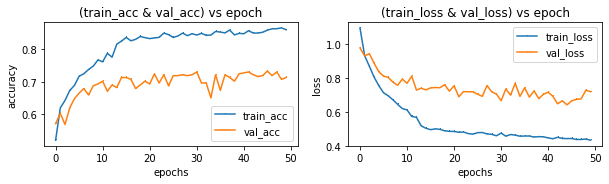

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
# f.savefig('C:/Users/DHANVANTH/SAMSUNG/resnet_50_epoch_vs_acc', bbox_inches='tight', dpi=600)

In [ ]:
#model _1 = tensorflow.keras.models.load_model('ResNet50_100_epochs.h5')

1/1 [==============================] - 0s 22ms/step


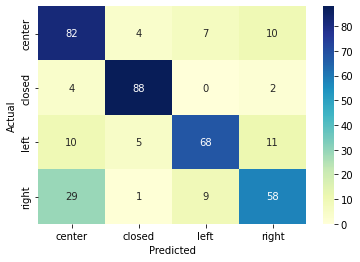

test accuracy: 76.28865979381443


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
#model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['center', 'closed', 'left', 'right']

ROC AUC score: 0.8434501448369864


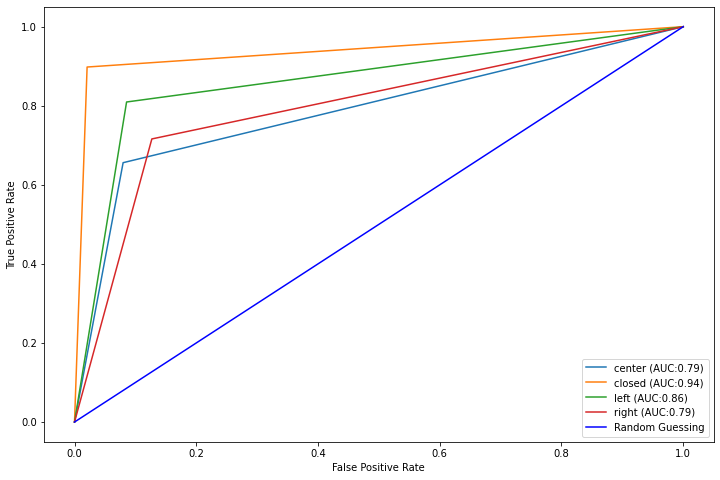

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
#for image augmentation 
model_1 = model

In [ ]:
# finetuning
for layer in model_1.layers:
    layer.trainable = True
    print("number of layers in model_1:", len(model_1.layers))
    fine_tune_at = 120
for layer in model_1.layers[:fine_tune_at]:
    layer.trainable = False

opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
model_1.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

model = model_1
model.summary()

number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of layers in model_1: 157
number of 

In [ ]:
# 50 epochs for mobilenet model finetuning[finetuning from 120th layer]
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
# checkpoint_path = "C:/Users/Janani/GAIP_NUS/Eye Motion/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.000001)

#csv_logger = CSVLogger('train_log1.csv', separator=',')

# Save the weights using the `checkpoint_path` format
model_1.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model_1.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
97/97 [==============================] - ETA: 0s - loss: 0.9784 - accuracy: 0.6099 - mse: 0.1323
Epoch 1: val_accuracy improved from -inf to 0.49716, saving model to /content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001
97/97 [==============================] - 54s 520ms/step - loss: 0.9784 - accuracy: 0.6099 - mse: 0.1323 - val_loss: 1.9956 - val_accuracy: 0.4972 - val_mse: 0.1894 - lr: 1.0000e-04
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.7656 - mse: 0.0800
Epoch 2: val_accuracy did not improve from 0.49716
97/97 [==============================] - 47s 483ms/step - loss: 0.5779 - accuracy: 0.7656 - mse: 0.0800 - val_loss: 3.2509 - val_accuracy: 0.3551 - val_mse: 0.2663 - lr: 1.0000e-04
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8204 - mse: 0.0623
Epoch 3: val_accuracy did not improve from 0.49716
97/97 [==============================] - 48s 490ms/step - loss: 0.4483 - accuracy: 0.82

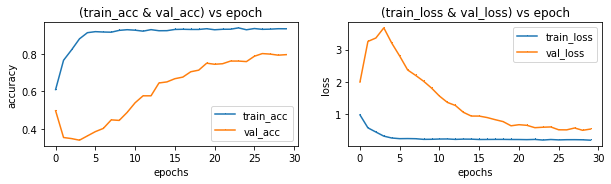

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
# f.savefig('C:/Users/DHANVANTH/SAMSUNG/resnet_50_epoch_vs_acc', bbox_inches='tight', dpi=600)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/mobileNet_f.h5')

1/1 [==============================] - 0s 20ms/step


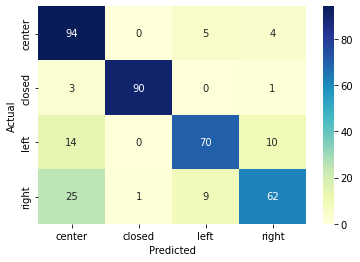

test accuracy: 81.44329896907216


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
#model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['center', 'closed', 'left', 'right']

ROC AUC score: 0.8796650697353016


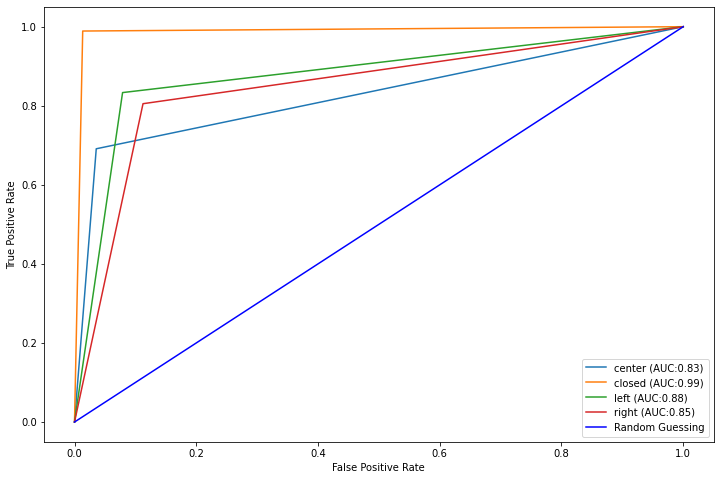

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
y_act

[array([[1., 0., 0., 0.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0.]], dtype=float32),
 array([[0., 1., 0., 0.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 1.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 1., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 1.]], dtype=float32),
 array([[1., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 1., 0., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0.]], dtype=float32),
 array([[0.